In [2]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.0 MB/s eta 0:00:00


In [3]:
import os, pathlib, shutil, random
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# Download and extract IMDB dataset
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  16.5M      0  0:00:04  0:00:04 --:--:-- 19.5M


In [5]:
import os

def summarize_imdb_files(base_path="aclImdb", num_files=5):
    for split in ["train", "test"]:
        print(f"\nSummary of '{split}' split:")
        for sentiment in ["pos", "neg"]:
            print(f"  Sentiment: {sentiment}")
            folder_path = os.path.join(base_path, split, sentiment)
            files = os.listdir(folder_path)[:num_files]  # Read first `num_files` files
            for i, file_name in enumerate(files):
                file_path = os.path.join(folder_path, file_name)
                with open(file_path, "r", encoding="utf-8") as f:
                    content = f.readlines()
                print(f"\n  File {i + 1}: {file_name}")
                print(f"    Lines in file: {len(content)}")
                print(f"    First 5 lines (or fewer):")
                print("    " + "\n    ".join(content[:5]).strip())


In [6]:
summarize_imdb_files()


Summary of 'train' split:
  Sentiment: pos

  File 1: 7880_8.txt
    Lines in file: 1
    First 5 lines (or fewer):
    The plot of this enjoyable MGM musical is contrived and only occasionally amusing, dealing with espionage and romance but the focus of the film is properly pointed upon the tuneful interludes showcasing the enormously talented and athletic tap dancing Eleanor Powell, abetted by Tommy Dorsey and his orchestra, featuring Ziggy Elman, Buddy Rich and Frank Sinatra. Red Skelton shares top billing with Powell, and he and sidekick Bert Lahr are given most of the comedic minutes, although Skelton is more effective when he, if it can be believed, performs as Powell's love interest, with Virginia O'Brien actually providing most of the film's humor as the dancer's companion. The technical brilliance of Powell is evidenced during one incredible scene within which Buddy Rich contributes his drumming skills, and which must be viewed several times in order to permit one's breathing

In [7]:
# Prepare directories
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category, exist_ok=True)  # Allow existing directories
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        # Only move files if they don't already exist at the destination
        if not os.path.exists(val_dir / category / fname):
            shutil.move(train_dir / category / fname, val_dir / category / fname)


In [8]:
# Load datasets
train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)

val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)

test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

text_only_train_ds = train_ds.map(lambda x, y: x)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [9]:
# Set parameters
max_length = 150
max_tokens = 10000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

text_vectorization.adapt(text_only_train_ds)


In [10]:
# Tokenized datasets
int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(100)  # Restrict training samples to 100

int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4).take(10000)  # Restrict validation samples to 10,000

int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)


In [13]:
# Model with an Embedding Layer
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=128)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
embedding_model = keras.Model(inputs, outputs)

embedding_model.compile(optimizer="rmsprop",
                        loss="binary_crossentropy",
                        metrics=["accuracy"])

embedding_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, None, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,321,281 (5.04 MB)

 Trainable params: 1,321,281 (5.04 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
callbacks = [
    keras.callbacks.ModelCheckpoint("embedding_model.keras", save_best_only=True)
]


In [15]:
history_embedded = embedding_model.fit(
    int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.5016 - loss: 0.6932 - val_accuracy: 0.5574 - val_loss: 0.6847
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6368 - loss: 0.6443 - val_accuracy: 0.7596 - val_loss: 0.5212
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.7799 - loss: 0.4918 - val_accuracy: 0.7878 - val_loss: 0.4715
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8425 - loss: 0.3806 - val_accuracy: 0.8122 - val_loss: 0.4382
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.8848 - loss: 0.3007 - val_accuracy: 0.7934 - val_loss: 0.4472
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9003 - loss: 0.2656 - val_accuracy: 0.7882 - val_loss: 0.5201
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9350 - loss: 0.1899 - val_accuracy: 0.7966 - val_loss: 0.4975
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9459 - loss: 0.1588 - val_acc

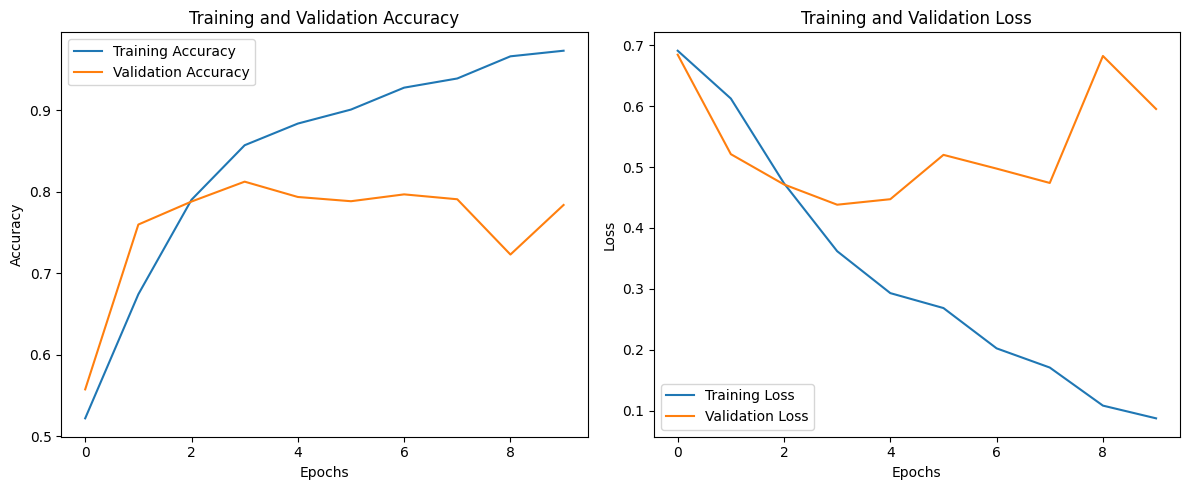

In [16]:
import matplotlib.pyplot as plt

# Extract the history of metrics
history = history_embedded.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the graph
plt.tight_layout()
plt.show()


In [17]:
# Model with Pretrained Word Embeddings

# Download GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip


--2025-04-08 12:43:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-08 12:43:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-08 12:43:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [18]:
# Prepare GloVe embedding matrix
embedding_dim = 100
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [19]:
# Pretrained embedding model
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
pretrained_model = keras.Model(inputs, outputs)


In [20]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
pretrained_model = keras.Model(inputs, outputs)

pretrained_model.compile(optimizer="rmsprop",
                         loss="binary_crossentropy",
                         metrics=["accuracy"])

pretrained_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 100)      │      1,000,000 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, None)           │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 64)             │         34,048 │ embedding_3[1][0],     │
│ (Bidirectional)           │                        │                │ not_equal_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 64)             │              0 │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint("pretrained_model.keras", save_best_only=True)
]

history_pretrained = pretrained_model.fit(
    int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks
)


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.5565 - loss: 0.6871 - val_accuracy: 0.6372 - val_loss: 0.6378
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 118ms/step - accuracy: 0.6663 - loss: 0.6146 - val_accuracy: 0.6798 - val_loss: 0.5932
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.6910 - loss: 0.5856 - val_accuracy: 0.7350 - val_loss: 0.5363
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.7347 - loss: 0.5395 - val_accuracy: 0.7294 - val_loss: 0.5414
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.7571 - loss: 0.5001 - val_accuracy: 0.7660 - val_loss: 0.4933
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.7631 - loss: 0.4955 - val_accuracy: 0.7062 - val_loss: 0.5538
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.7743 - loss: 0.4728 - val_accuracy: 0.7554 - val_loss: 0.5096
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.7830 - loss: 0

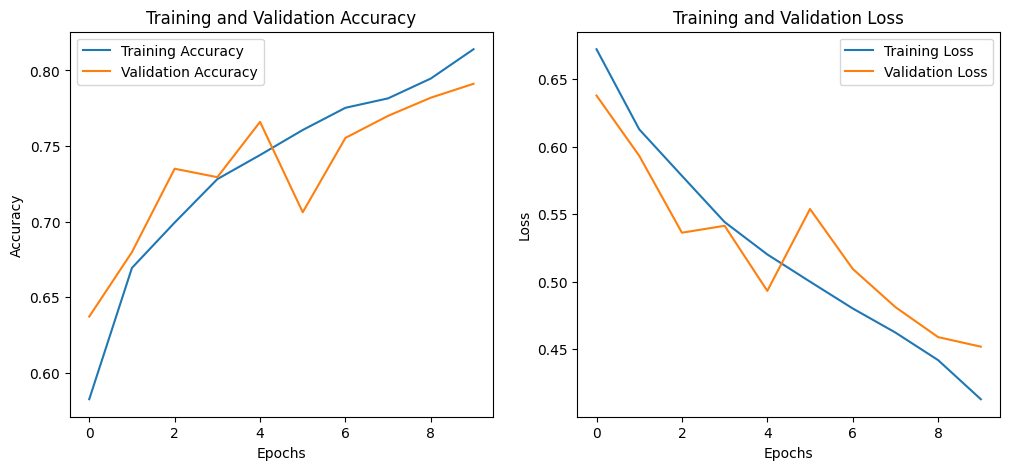

In [22]:
import matplotlib.pyplot as plt

# Extract the history of metrics
history = history_pretrained.history

# Create a figure for the plots
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the graph
plt.show()




### Training with 100 samples ###

Training Custom Embedding Model with 100 samples:
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.9848 - loss: 0.0508 - val_accuracy: 0.8026 - val_loss: 0.5691
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9862 - loss: 0.0454 - val_accuracy: 0.7934 - val_loss: 0.6764
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9844 - loss: 0.0533 - val_accuracy: 0.7678 - val_loss: 0.5945
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.9849 - loss: 0.0515 - val_accuracy: 0.7532 - val_loss: 0.6656
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9935 - loss: 0.0255 - val_accuracy: 0.7706 - val_loss: 0.8251
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9974 - loss: 0.0112 - val_accuracy: 0.7214 - val_loss: 1.1663
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9966 - loss: 0.0130 - val_accuracy: 0.7352 - val_loss: 0.9324
Epoch 8/10


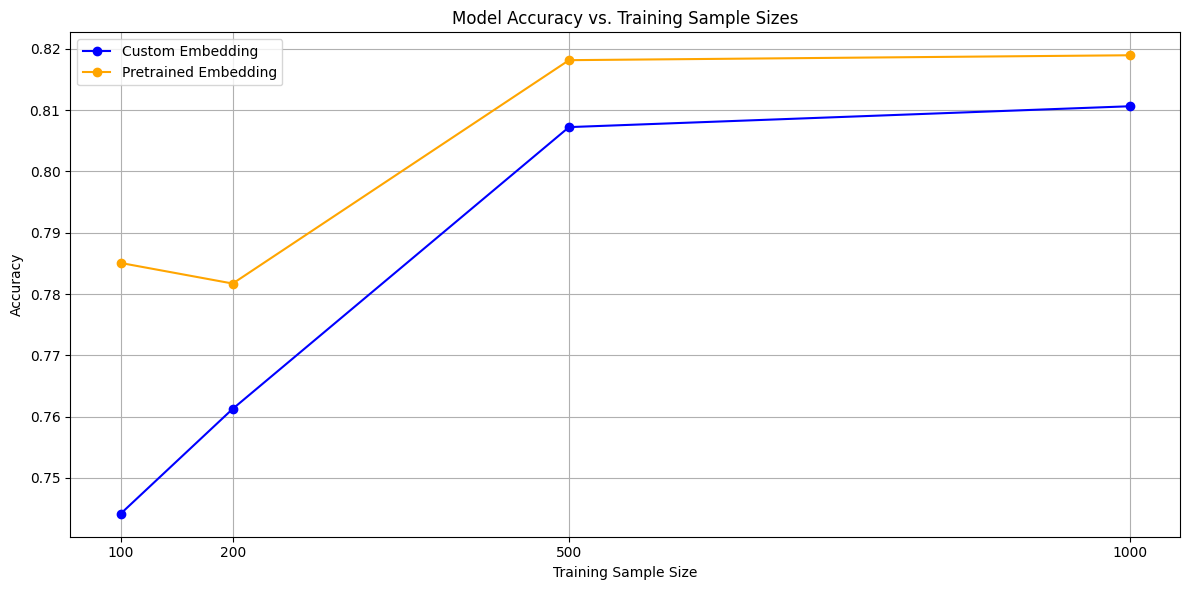

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Data
data_counts = [100, 200, 500, 1000]
custom_embed_scores = []
pretrained_embed_scores = []

# Initialize the plot
plt.figure(figsize=(12, 6))
plt.title('Model Accuracy vs. Training Sample Sizes')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.grid(True)

# Iterate over sample sizes
for i, size in enumerate(data_counts):
    print(f"\n### Training with {size} samples ###\n")

    # Update training dataset with the specific size
    small_train_ds = train_ds.map(
        lambda x, y: (text_vectorization(x), y)).take(size)

    # Train custom embedding model
    print(f"Training Custom Embedding Model with {size} samples:")
    embedding_model.fit(
        small_train_ds,
        validation_data=int_val_ds,
        epochs=10,
        verbose=1  # Displays training progress for each epoch
    )
    embedding_acc = embedding_model.evaluate(int_test_ds, verbose=1)[1]
    custom_embed_scores.append(embedding_acc)
    print(f"Custom Embedding Model Accuracy: {embedding_acc:.4f}\n")

    # Train pretrained embedding model
    print(f"Training Pretrained Embedding Model with {size} samples:")
    pretrained_model.fit(
        small_train_ds,
        validation_data=int_val_ds,
        epochs=10,
        verbose=1
    )
    pretrained_acc = pretrained_model.evaluate(int_test_ds, verbose=1)[1]
    pretrained_embed_scores.append(pretrained_acc)
    print(f"Pretrained Embedding Model Accuracy: {pretrained_acc:.4f}\n")

    # Update the plot dynamically after each iteration
    if i == len(data_counts) - 1:  # Once all iterations are done, plot the final line graph
        plt.plot(data_counts, custom_embed_scores, marker='o', label='Custom Embedding', color='blue')
        plt.plot(data_counts, pretrained_embed_scores, marker='o', label='Pretrained Embedding', color='orange')

# Final plot styling
plt.title('Model Accuracy vs. Training Sample Sizes')
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.xticks(data_counts)  # Set x-ticks to sample sizes
plt.grid(True)
plt.legend()

# Show the final plot
plt.tight_layout()
plt.show()



In [24]:
import pandas as pd

# Collect results for custom embedding model
custom_embedding_results = {
    "Sample Size": data_counts,
    "Custom Embedding Accuracy": custom_embed_scores,
}

# Collect results for pretrained embedding model
pretrained_embedding_results = {
    "Sample Size": data_counts,
    "Pretrained Embedding Accuracy": pretrained_embed_scores,
}

# Combine into a single DataFrame
summary_df = pd.DataFrame({
    "Sample Size": data_counts,
    "Custom Embedding Accuracy": custom_embed_scores,
    "Pretrained Embedding Accuracy": pretrained_embed_scores
})

# Display the table
print("Summary of Results:")
print(summary_df)


Summary of Results:
   Sample Size  Custom Embedding Accuracy  Pretrained Embedding Accuracy
0          100                    0.74416                        0.78508
1          200                    0.76128                        0.78172
2          500                    0.80724                        0.81816
3         1000                    0.81064                        0.81896


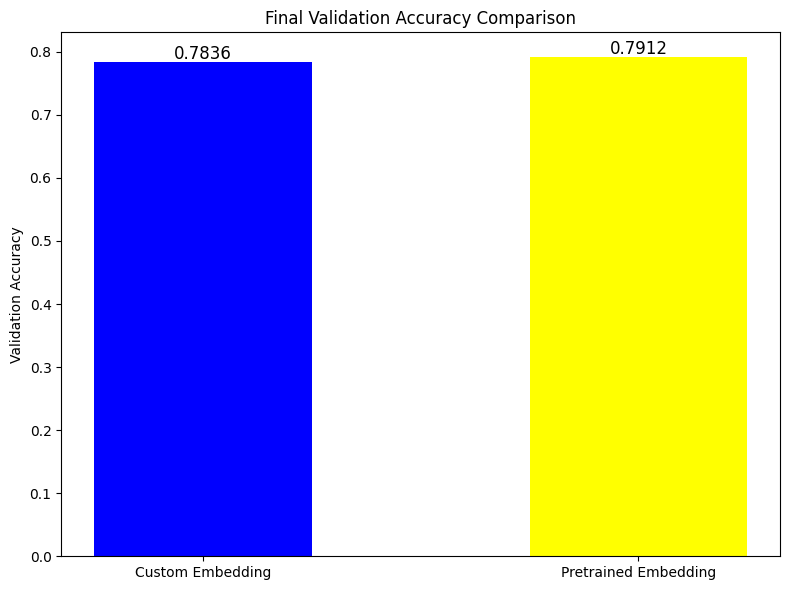

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Data
models = ['Custom Embedding', 'Pretrained Embedding']
final_val_accuracies = [
    history_embedded.history['val_accuracy'][-1],  # Final validation accuracy for custom embedding
    history_pretrained.history['val_accuracy'][-1]  # Final validation accuracy for pretrained embedding
]

# Bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, final_val_accuracies, color=['blue', 'yellow'], width=0.5)

# Add labels and title
plt.ylabel('Validation Accuracy')
plt.title('Final Validation Accuracy Comparison')

# Display final values on top of bars
for i, v in enumerate(final_val_accuracies):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


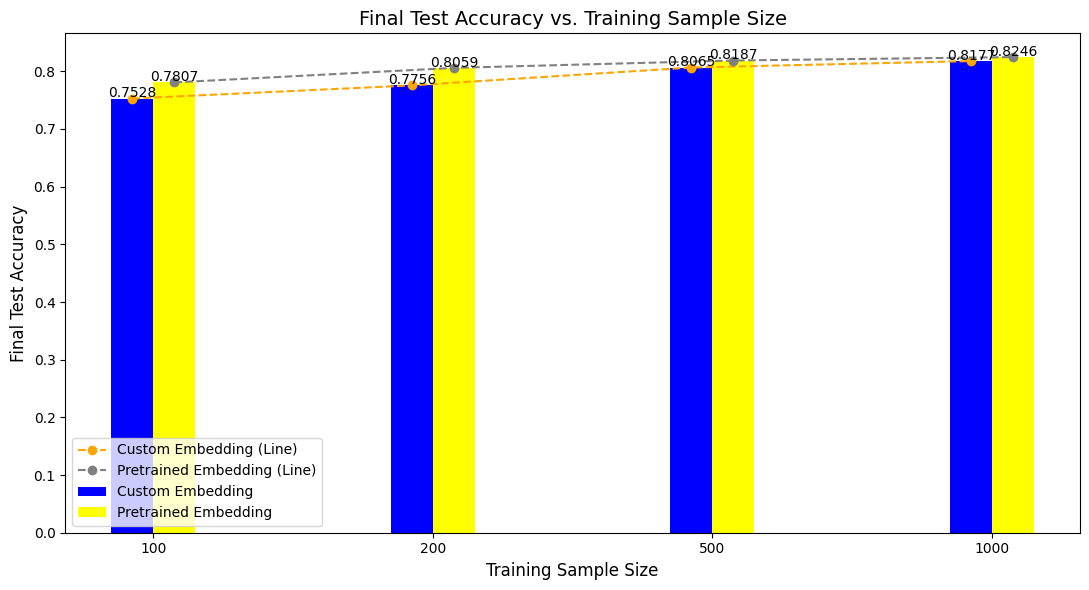

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Data
data_counts = [100, 200, 500, 1000]
custom_embed_scores = [0.75280, 0.77556, 0.80652, 0.81772]  # Replace with actual final values
pretrained_embed_scores = [0.78072, 0.80588, 0.81868, 0.82456]  # Replace with actual final values

# Bar width and positions
column_width = 0.15
x_pos = np.arange(len(data_counts))  # Base positions for bars

# Plot bars
plt.figure(figsize=(11, 6))
plt.bar(x_pos - column_width / 2, custom_embed_scores,
        width=column_width, label='Custom Embedding', color='blue')
plt.bar(x_pos + column_width / 2, pretrained_embed_scores,
        width=column_width, label='Pretrained Embedding', color='yellow')

# Overlay lines for comparison
plt.plot(x_pos - column_width / 2, custom_embed_scores,
         marker='o', color='orange', linestyle='--', label='Custom Embedding (Line)')
plt.plot(x_pos + column_width / 2, pretrained_embed_scores,
         marker='o', color='grey', linestyle='--', label='Pretrained Embedding (Line)')

# Add labels and title
plt.xlabel('Training Sample Size', fontsize=12)
plt.ylabel('Final Test Accuracy', fontsize=12)
plt.title('Final Test Accuracy vs. Training Sample Size', fontsize=14)
plt.xticks(x_pos, data_counts)  # Use sample sizes as x-tick labels
plt.legend()

# Annotate bars with final accuracy values
for i in range(len(data_counts)):
    plt.text(x_pos[i] - column_width / 2, custom_embed_scores[i] + 0.002,
             f'{custom_embed_scores[i]:.4f}', ha='center', fontsize=10)
    plt.text(x_pos[i] + column_width / 2, pretrained_embed_scores[i] + 0.002,
             f'{pretrained_embed_scores[i]:.4f}', ha='center', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
